# Hate Speech with LLM

This is practical exercise to see how LLM models like Ollama can help us to solve classification problems. I will be using two datasets and use prompt engineering to evalaute first the model without any fine-tunning. Then I will fine-tune the model and then I will compare the results.

In [1]:
### Loading helpful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

## Load the Hate Speech Data 1

In [2]:
### Loading the dataset
hate_speech_1 = pd.read_csv('data/hate-speech-data-1.csv')

In [3]:
### Exploring the dataset
hate_speech_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [4]:
### Checking a few records of the dataset
hate_speech_1.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Identifying the important features

- tweet: The text which might contain a hateful content
- class: 
    - 0: Hate content
    - 1: Offensive
    - 2: Neighter or normal content

## Cleaning a bit this dataset

In [5]:
### Dropping unnecessary columns
hate_speech_1.drop(columns=['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], inplace=True)
hate_speech_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [6]:
### Checking null values
hate_speech_1.isnull().sum()

class    0
tweet    0
dtype: int64

In [7]:
### Checking if there are empty tweets
hate_speech_1[hate_speech_1['tweet'] == '']

,class,tweet


In [8]:
### Fixing the class to match the following pattern: 0 = not hate speech, 1 = hate speech
hate_speech_1['class'] = hate_speech_1['class'].apply(lambda label: 0 if label == 2 else 1 )

## Load the Hate Speech Data 2

In [9]:
### Loading the dataset
hate_speech_2 = pd.read_csv('data/hate-speech-data-2.csv')

In [10]:
### Exploring the dataset
hate_speech_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726119 entries, 0 to 726118
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  726119 non-null  object
 1   Label    726119 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ MB


In [11]:
### Checking a few records of the dataset
hate_speech_2.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


## Identifying the important features

- content: The text which might contain a hateful content
- label: 
    - 0: Normal content
    - 1: Offensive or hateful

## Cleaning a bit this dataset

In [12]:
### Checking null values
hate_speech_2.isnull().sum()

Content    0
Label      0
dtype: int64

In [13]:
### Checking if there are empty Contents
hate_speech_2[hate_speech_2['Content'] == '']

,Content,Label


# EDA Analisys

## 1. Checking label distribution

In [14]:
### Checking the actual distribution of the classes
hate_speech_1['class'].value_counts()

class
1    20620
0     4163
Name: count, dtype: int64

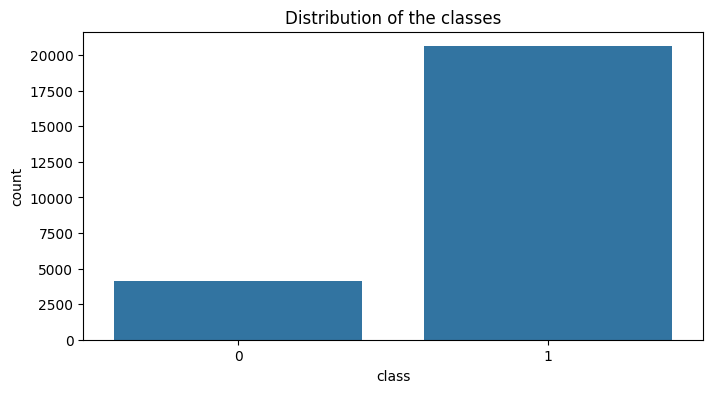

In [15]:
### Plotting the distribution of the classes using barplot
plt.figure(figsize=(8, 4))
sns.countplot(x='class', data=hate_speech_1)
plt.title('Distribution of the classes')
plt.show()

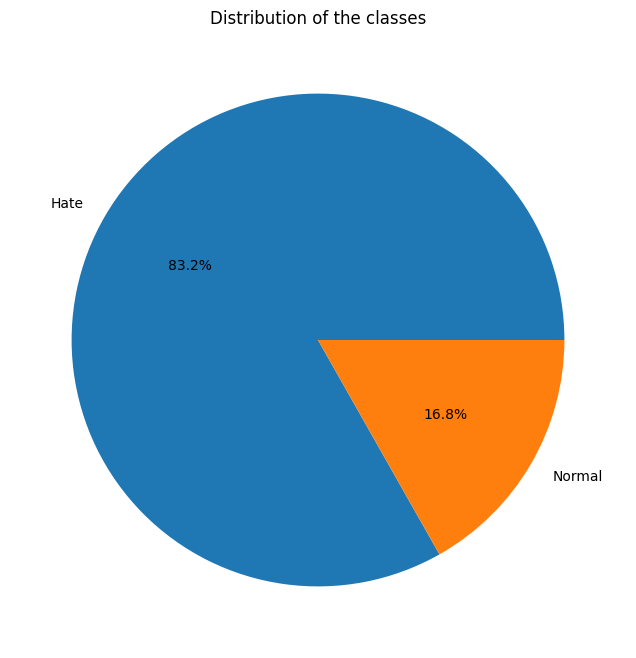

In [16]:
### Plotting the distribution of the classes using pie chart
plt.figure(figsize=(8, 8))
plt.pie(hate_speech_1['class'].value_counts(), labels=["Hate", "Normal"], autopct='%1.1f%%')
plt.title('Distribution of the classes')
plt.show()

## 2. Checking the text word count metrics

In [17]:
### Creating extra feature to count the number of words in each tweet
hate_speech_1['tweet_word_count'] = hate_speech_1['tweet'].apply(lambda x: len(x.split()))
hate_speech_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   class             24783 non-null  int64 
 1   tweet             24783 non-null  object
 2   tweet_word_count  24783 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 581.0+ KB


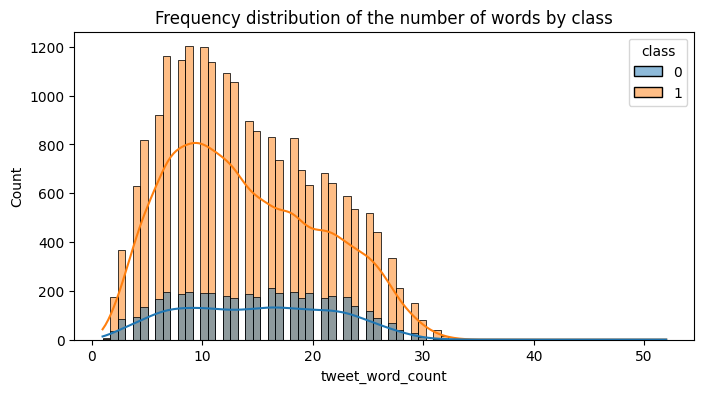

In [18]:
### Plotting the frequency distribution of the number of words by class
plt.figure(figsize=(8, 4))
sns.histplot(data=hate_speech_1, x='tweet_word_count', hue='class', kde=True)
plt.title('Frequency distribution of the number of words by class')
plt.show()

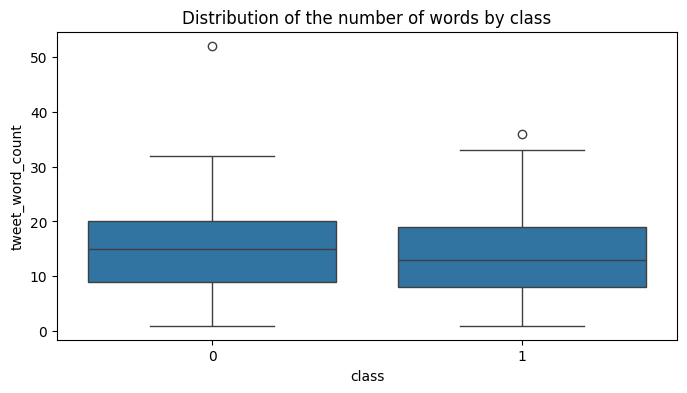

In [19]:
### Checking the distribution of the number of words by class using boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x='class', y='tweet_word_count', data=hate_speech_1)
plt.title('Distribution of the number of words by class')
plt.show()

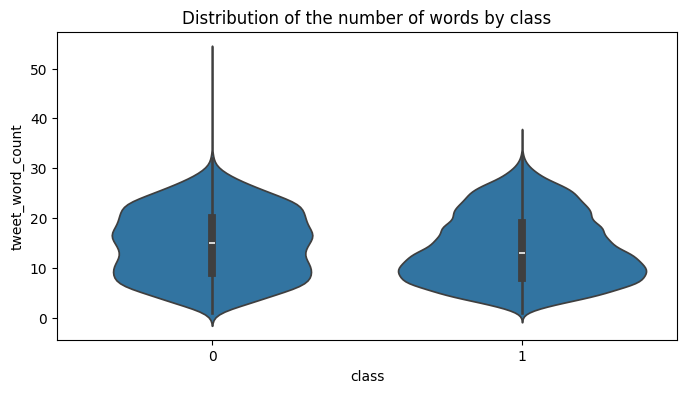

In [20]:
### Checking the distribution of the number of words by class using violinplot
plt.figure(figsize=(8, 4))
sns.violinplot(x='class', y='tweet_word_count', data=hate_speech_1)
plt.title('Distribution of the number of words by class')
plt.show()

## 3. Generating wordcloud between texts with hate content and ones without it

In [21]:
### Downloading nltk dependencies
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/diegoagd10/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegoagd10/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/diegoagd10/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
### Splitting the texts by hate speech and normal
hate_speech = hate_speech_1[hate_speech_1['class'] == 1]['tweet']
normal = hate_speech_1[hate_speech_1['class'] == 0]['tweet']

In [23]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords.words("english")).generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

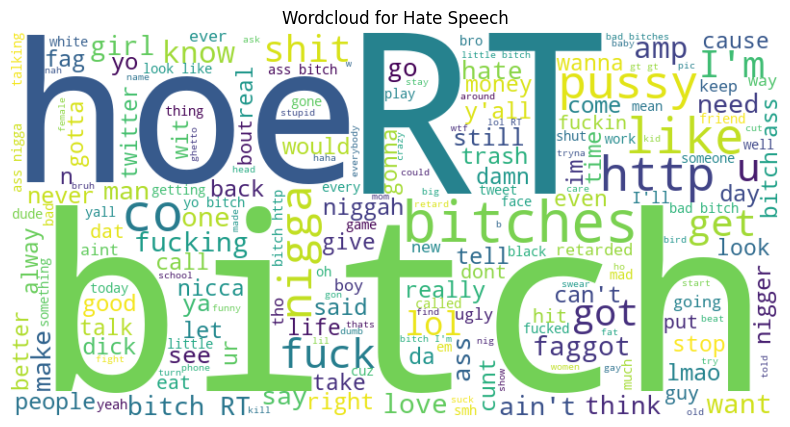

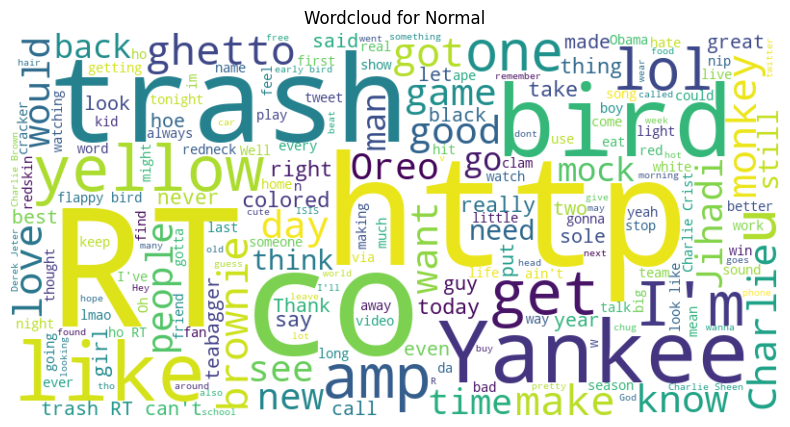

In [24]:
### Generating wordclouds
generate_wordcloud(hate_speech, 'Wordcloud for Hate Speech')
generate_wordcloud(normal, 'Wordcloud for Normal')

## Observations

1. I'm dealing with an imbalanced dataset, so I might need to reduce the number of hate values randomly

2. Shorter texts tend to be hateful.

3. The word cloud for hateful content highligth bad words.

# Working with the LLM

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer